In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-05-24 03:18:04.817718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 03:18:04.817772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = shuffle(data, random_state=42)

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=ratio, random_state=42)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
        training = train_data
        test = test_data

        training = training[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
        test = test[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]


    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [1,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    max_test_accuracy_index = model.history['val_accuracy'].index(max(model.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = model.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(model.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)


    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    print("Total F1 Score:", total_f1)

    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
    print("Total Accuracy:", total_accuracy)

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
13/13 [==============================] - 2s 42ms/step - loss: 1.7642 - accuracy: 0.1020 - val_loss: 1.6842 - val_accuracy: 0.2222
Epoch 2/150
13/13 [==============================] - 0s 10ms/step - loss: 1.7638 - accuracy: 0.2857 - val_loss: 1.6343 - val_accuracy: 0.4259
Epoch 3/150
13/13 [==============================] - 0s 11ms/step - loss: 1.6728 - accuracy: 0.3469 - val_loss: 1.5873 - val_accuracy: 0.4630
Epoch 4/150
13/13 [==============================] - 0s 11ms/step - loss: 1.7070 - accuracy: 0.3265 - val_loss: 1.5446 - val_accuracy: 0.6296
Epoch 5/150
13/13 [==============================] - 0s 8ms/step - loss: 1.5643 - accuracy: 0.4082 - val_loss: 1.5036 - val_accuracy: 0.6296
Epoch 6/150
13/13 [==============================] - 0s 7ms/step - loss: 1.5435 - accuracy: 0.4694 - val_loss: 1.4650 - val_accuracy: 0.6296
Epoch 7/150
13/13 [==============================] - 0s 7ms/step - loss: 1.5070 - accuracy: 0.4898 - val_loss: 1.4289 - val_accuracy: 0.6296
Epoch 8/1

Epoch 59/150
13/13 [==============================] - 0s 8ms/step - loss: 0.7762 - accuracy: 0.7551 - val_loss: 0.6769 - val_accuracy: 0.7037
Epoch 60/150
13/13 [==============================] - 0s 7ms/step - loss: 0.7197 - accuracy: 0.7551 - val_loss: 0.6709 - val_accuracy: 0.7037
Epoch 61/150
13/13 [==============================] - 0s 7ms/step - loss: 0.7588 - accuracy: 0.7551 - val_loss: 0.6658 - val_accuracy: 0.7037
Epoch 62/150
13/13 [==============================] - 0s 7ms/step - loss: 0.7322 - accuracy: 0.7551 - val_loss: 0.6606 - val_accuracy: 0.7037
Epoch 63/150
13/13 [==============================] - 0s 7ms/step - loss: 0.7327 - accuracy: 0.7143 - val_loss: 0.6555 - val_accuracy: 0.7037
Epoch 64/150
13/13 [==============================] - 0s 9ms/step - loss: 0.6870 - accuracy: 0.7551 - val_loss: 0.6505 - val_accuracy: 0.7037
Epoch 65/150
13/13 [==============================] - 0s 8ms/step - loss: 0.7509 - accuracy: 0.7347 - val_loss: 0.6457 - val_accuracy: 0.7037
Epoch 

13/13 [==============================] - 0s 11ms/step - loss: 0.6236 - accuracy: 0.7959 - val_loss: 0.5053 - val_accuracy: 0.7963
Epoch 117/150
13/13 [==============================] - 0s 7ms/step - loss: 0.6061 - accuracy: 0.7959 - val_loss: 0.5027 - val_accuracy: 0.7778
Epoch 118/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5870 - accuracy: 0.7959 - val_loss: 0.5006 - val_accuracy: 0.7778
Epoch 119/150
13/13 [==============================] - 0s 11ms/step - loss: 0.5160 - accuracy: 0.7551 - val_loss: 0.4991 - val_accuracy: 0.8148
Epoch 120/150
13/13 [==============================] - 0s 7ms/step - loss: 0.6164 - accuracy: 0.7551 - val_loss: 0.4978 - val_accuracy: 0.8148
Epoch 121/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5365 - accuracy: 0.8367 - val_loss: 0.4961 - val_accuracy: 0.8148
Epoch 122/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5878 - accuracy: 0.7959 - val_loss: 0.4944 - val_accuracy: 0.8148
Epoch 123/1

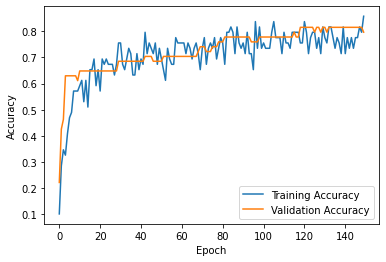

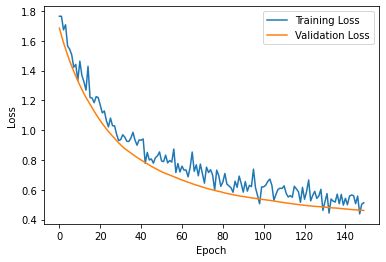

Best validation accuracy: 0.8148148059844971
Training accuracy at the best test accuracy: 0.7551020383834839
Best validation accuracy: 0.8148148059844971
Training accuracy at the best test accuracy: 0.7551020383834839
Confusion matrix:
[[12  0  0  0  0  0]
 [ 0  3  0  0  1  0]
 [ 0  0  3  0  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  5  1  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 68.96551724137932
Accuracy for 4 : 50.0
Accuracy for 5 : 80.0
Total Precision: 0.8316091954022989
Total Recall: 0.7281746031746031
Total F1 Score: 0.7537545787545787
Accuracy for each label: [100.         100.         100.          68.96551724  50.
  80.        ]
Precision for each label: [1.         1.         1.         0.68965517 0.5        0.8       ]
Recall for each label: [1.         0.75       1.         0.95238095 0.16666667 0.5       ]
F1 Score for each label: [1.         0.85714286 1.         0.8        0.25       0.61538462]
Total Acc

In [14]:
run_model(ratio_1, callback_1)

/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
15/15 [==============================] - 1s 30ms/step - loss: 1.9488 - accuracy: 0.1000 - val_loss: 2.0912 - val_accuracy: 0.1163
Epoch 2/150
15/15 [==============================] - 0s 10ms/step - loss: 2.0040 - accuracy: 0.1000 - val_loss: 2.0245 - val_accuracy: 0.2326
Epoch 3/150
15/15 [==============================] - 0s 12ms/step - loss: 1.8621 - accuracy: 0.2000 - val_loss: 1.9658 - val_accuracy: 0.3256
Epoch 4/150
15/15 [==============================] - 0s 6ms/step - loss: 1.7446 - accuracy: 0.2333 - val_loss: 1.9117 - val_accuracy: 0.3256
Epoch 5/150
15/15 [==============================] - 0s 9ms/step - loss: 1.8366 - accuracy: 0.2667 - val_loss: 1.8600 - val_accuracy: 0.3256
Epoch 6/150
15/15 [==============================] - 0s 10ms/step - loss: 1.7761 - accuracy: 0.3167 - val_loss: 1.8116 - val_accuracy: 0.3488
Epoch 7/150
15/15 [==============================] - 0s 11ms/step - loss: 1.6360 - accuracy: 0.4000 - val_loss: 1.7658 - val_accuracy: 0.3721
Epoch 8/

Epoch 59/150
15/15 [==============================] - 0s 7ms/step - loss: 0.7641 - accuracy: 0.6667 - val_loss: 0.8590 - val_accuracy: 0.6512
Epoch 60/150
15/15 [==============================] - 0s 7ms/step - loss: 0.8799 - accuracy: 0.6667 - val_loss: 0.8556 - val_accuracy: 0.6512
Epoch 61/150
15/15 [==============================] - 0s 6ms/step - loss: 0.7534 - accuracy: 0.7000 - val_loss: 0.8464 - val_accuracy: 0.6512
Epoch 62/150
15/15 [==============================] - 0s 6ms/step - loss: 0.7764 - accuracy: 0.6833 - val_loss: 0.8365 - val_accuracy: 0.6512
Epoch 63/150
15/15 [==============================] - 0s 7ms/step - loss: 0.8055 - accuracy: 0.6833 - val_loss: 0.8300 - val_accuracy: 0.6512
Epoch 64/150
15/15 [==============================] - 0s 8ms/step - loss: 0.6712 - accuracy: 0.7333 - val_loss: 0.8161 - val_accuracy: 0.6512
Epoch 65/150
15/15 [==============================] - 0s 11ms/step - loss: 0.7566 - accuracy: 0.7167 - val_loss: 0.8094 - val_accuracy: 0.6744
Epoch

15/15 [==============================] - 0s 7ms/step - loss: 0.5649 - accuracy: 0.8167 - val_loss: 0.5350 - val_accuracy: 0.7674
Epoch 117/150
15/15 [==============================] - 0s 9ms/step - loss: 0.5297 - accuracy: 0.7500 - val_loss: 0.5343 - val_accuracy: 0.7674
Epoch 118/150
15/15 [==============================] - 0s 6ms/step - loss: 0.5421 - accuracy: 0.7500 - val_loss: 0.5319 - val_accuracy: 0.7674
Epoch 119/150
15/15 [==============================] - 0s 7ms/step - loss: 0.5290 - accuracy: 0.7833 - val_loss: 0.5317 - val_accuracy: 0.7674
Epoch 120/150
15/15 [==============================] - 0s 7ms/step - loss: 0.5602 - accuracy: 0.7667 - val_loss: 0.5307 - val_accuracy: 0.7674
Epoch 121/150
15/15 [==============================] - 0s 7ms/step - loss: 0.4800 - accuracy: 0.8167 - val_loss: 0.5289 - val_accuracy: 0.7674
Epoch 122/150
15/15 [==============================] - 0s 7ms/step - loss: 0.4784 - accuracy: 0.7833 - val_loss: 0.5256 - val_accuracy: 0.7442
Epoch 123/150

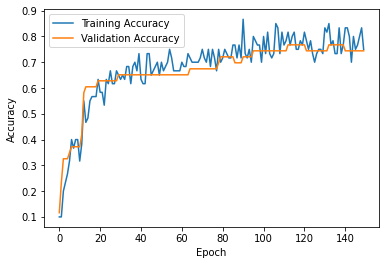

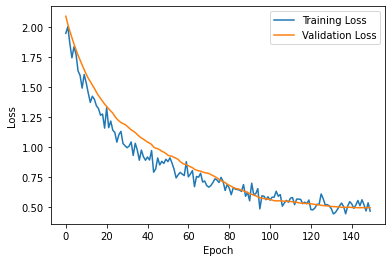

Best validation accuracy: 0.7674418687820435
Training accuracy at the best test accuracy: 0.8166666626930237
Best validation accuracy: 0.7674418687820435
Training accuracy at the best test accuracy: 0.8166666626930237
Confusion matrix:
[[10  0  0  0  0  0]
 [ 0  2  0  0  1  0]
 [ 1  0  1  0  0  0]
 [ 0  0  0 17  0  0]
 [ 0  1  0  4  0  0]
 [ 0  0  0  4  0  2]]
Accuracy for 0 : 90.9090909090909
Accuracy for 1 : 66.66666666666666
Accuracy for 2 : 100.0
Accuracy for 3 : 68.0
Accuracy for 4 : 0.0
Accuracy for 5 : 100.0
Total Precision: 0.7092929292929293
Total Recall: 0.5833333333333334
Total F1 Score: nan
Accuracy for each label: [ 90.90909091  66.66666667 100.          68.           0.
 100.        ]
Precision for each label: [0.90909091 0.66666667 1.         0.68       0.         1.        ]
Recall for each label: [1.         0.66666667 0.5        1.         0.         0.33333333]
F1 Score for each label: [0.95238095 0.66666667 0.66666667 0.80952381        nan 0.5       ]
Total Accuracy

/tmp/ipykernel_47277/1781135939.py:55: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [15]:
run_model(ratio_2, callback_2)

/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
18/18 [==============================] - 1s 30ms/step - loss: 1.9052 - accuracy: 0.2464 - val_loss: 2.0891 - val_accuracy: 0.2941
Epoch 2/150
18/18 [==============================] - 0s 9ms/step - loss: 1.9029 - accuracy: 0.2899 - val_loss: 2.0306 - val_accuracy: 0.3529
Epoch 3/150
18/18 [==============================] - 0s 10ms/step - loss: 1.7717 - accuracy: 0.3478 - val_loss: 1.9721 - val_accuracy: 0.3824
Epoch 4/150
18/18 [==============================] - 0s 11ms/step - loss: 1.6523 - accuracy: 0.3913 - val_loss: 1.9183 - val_accuracy: 0.4706
Epoch 5/150
18/18 [==============================] - 0s 10ms/step - loss: 1.6713 - accuracy: 0.4638 - val_loss: 1.8588 - val_accuracy: 0.5588
Epoch 6/150
18/18 [==============================] - 0s 6ms/step - loss: 1.5872 - accuracy: 0.4928 - val_loss: 1.8067 - val_accuracy: 0.5588
Epoch 7/150
18/18 [==============================] - 0s 6ms/step - loss: 1.4778 - accuracy: 0.5217 - val_loss: 1.7599 - val_accuracy: 0.5588
Epoch 8/1

Epoch 59/150
18/18 [==============================] - 0s 6ms/step - loss: 0.7354 - accuracy: 0.6812 - val_loss: 0.7945 - val_accuracy: 0.6176
Epoch 60/150
18/18 [==============================] - 0s 7ms/step - loss: 0.7080 - accuracy: 0.7246 - val_loss: 0.7859 - val_accuracy: 0.6176
Epoch 61/150
18/18 [==============================] - 0s 6ms/step - loss: 0.6683 - accuracy: 0.7246 - val_loss: 0.7818 - val_accuracy: 0.6176
Epoch 62/150
18/18 [==============================] - 0s 6ms/step - loss: 0.6595 - accuracy: 0.7101 - val_loss: 0.7790 - val_accuracy: 0.6176
Epoch 63/150
18/18 [==============================] - 0s 6ms/step - loss: 0.6763 - accuracy: 0.7391 - val_loss: 0.7727 - val_accuracy: 0.6176
Epoch 64/150
18/18 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.7391 - val_loss: 0.7671 - val_accuracy: 0.6176
Epoch 65/150
18/18 [==============================] - 0s 6ms/step - loss: 0.7825 - accuracy: 0.7101 - val_loss: 0.7637 - val_accuracy: 0.6176
Epoch 

18/18 [==============================] - 0s 7ms/step - loss: 0.5613 - accuracy: 0.8116 - val_loss: 0.5995 - val_accuracy: 0.7059
Epoch 117/150
18/18 [==============================] - 0s 7ms/step - loss: 0.5012 - accuracy: 0.7681 - val_loss: 0.5964 - val_accuracy: 0.7353
Epoch 118/150
18/18 [==============================] - 0s 7ms/step - loss: 0.5346 - accuracy: 0.7536 - val_loss: 0.5899 - val_accuracy: 0.7353
Epoch 119/150
18/18 [==============================] - 0s 7ms/step - loss: 0.5593 - accuracy: 0.6957 - val_loss: 0.5859 - val_accuracy: 0.7353
Epoch 120/150
18/18 [==============================] - 0s 7ms/step - loss: 0.5711 - accuracy: 0.7391 - val_loss: 0.5841 - val_accuracy: 0.7353
Epoch 121/150
18/18 [==============================] - 0s 7ms/step - loss: 0.5495 - accuracy: 0.7246 - val_loss: 0.5829 - val_accuracy: 0.7353
Epoch 122/150
18/18 [==============================] - 0s 6ms/step - loss: 0.5116 - accuracy: 0.7536 - val_loss: 0.5780 - val_accuracy: 0.7353
Epoch 123/150

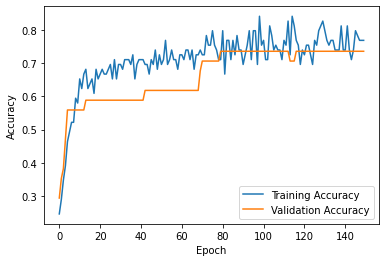

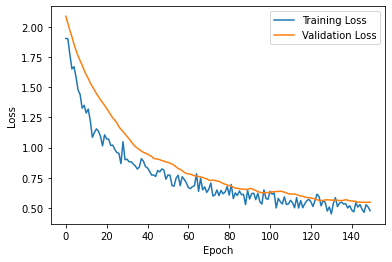

Best validation accuracy: 0.7352941036224365
Training accuracy at the best test accuracy: 0.7101449370384216
Best validation accuracy: 0.7352941036224365
Training accuracy at the best test accuracy: 0.7101449370384216
Confusion matrix:
[[ 7  0  0  0  0  0]
 [ 0  2  0  0  1  0]
 [ 1  0  1  0  0  0]
 [ 0  1  0 12  0  0]
 [ 0  1  0  3  0  0]
 [ 0  0  0  2  0  3]]
Accuracy for 0 : 87.5
Accuracy for 1 : 50.0
Accuracy for 2 : 100.0
Accuracy for 3 : 70.58823529411765
Accuracy for 4 : 0.0
Accuracy for 5 : 100.0
Total Precision: 0.6801470588235294
Total Recall: 0.6149572649572649
Total F1 Score: nan
Accuracy for each label: [ 87.5         50.         100.          70.58823529   0.
 100.        ]
Precision for each label: [0.875      0.5        1.         0.70588235 0.         1.        ]
Recall for each label: [1.         0.66666667 0.5        0.92307692 0.         0.6       ]
F1 Score for each label: [0.93333333 0.57142857 0.66666667 0.8               nan 0.75      ]
Total Accuracy: 73.5294117

/tmp/ipykernel_47277/1781135939.py:55: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [16]:
run_model(ratio_3, callback_3)

/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
20/20 [==============================] - 1s 25ms/step - loss: 2.0596 - accuracy: 0.0875 - val_loss: 1.8729 - val_accuracy: 0.0435
Epoch 2/150
20/20 [==============================] - 0s 8ms/step - loss: 1.9794 - accuracy: 0.1375 - val_loss: 1.7700 - val_accuracy: 0.3043
Epoch 3/150
20/20 [==============================] - 0s 5ms/step - loss: 1.8278 - accuracy: 0.2000 - val_loss: 1.6767 - val_accuracy: 0.3043
Epoch 4/150
20/20 [==============================] - 0s 9ms/step - loss: 1.7808 - accuracy: 0.2000 - val_loss: 1.5969 - val_accuracy: 0.3913
Epoch 5/150
20/20 [==============================] - 0s 11ms/step - loss: 1.7166 - accuracy: 0.2750 - val_loss: 1.5196 - val_accuracy: 0.4348
Epoch 6/150
20/20 [==============================] - 0s 6ms/step - loss: 1.6884 - accuracy: 0.3875 - val_loss: 1.4417 - val_accuracy: 0.4348
Epoch 7/150
20/20 [==============================] - 0s 6ms/step - loss: 1.5529 - accuracy: 0.4250 - val_loss: 1.3741 - val_accuracy: 0.4348
Epoch 8/150

Epoch 59/150
20/20 [==============================] - 0s 5ms/step - loss: 0.7299 - accuracy: 0.7125 - val_loss: 0.5884 - val_accuracy: 0.7391
Epoch 60/150
20/20 [==============================] - 0s 5ms/step - loss: 0.7034 - accuracy: 0.7250 - val_loss: 0.5887 - val_accuracy: 0.7391
Epoch 61/150
20/20 [==============================] - 0s 5ms/step - loss: 0.6403 - accuracy: 0.7625 - val_loss: 0.5850 - val_accuracy: 0.7391
Epoch 62/150
20/20 [==============================] - 0s 5ms/step - loss: 0.6649 - accuracy: 0.7250 - val_loss: 0.5852 - val_accuracy: 0.7391
Epoch 63/150
20/20 [==============================] - 0s 5ms/step - loss: 0.6623 - accuracy: 0.7375 - val_loss: 0.5856 - val_accuracy: 0.7391
Epoch 64/150
20/20 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.7125 - val_loss: 0.5819 - val_accuracy: 0.7391
Epoch 65/150
20/20 [==============================] - 0s 5ms/step - loss: 0.7032 - accuracy: 0.7500 - val_loss: 0.5767 - val_accuracy: 0.7391
Epoch 

20/20 [==============================] - 0s 5ms/step - loss: 0.5251 - accuracy: 0.7125 - val_loss: 0.5068 - val_accuracy: 0.7826
Epoch 117/150
20/20 [==============================] - 0s 5ms/step - loss: 0.5426 - accuracy: 0.7125 - val_loss: 0.5065 - val_accuracy: 0.7826
Epoch 118/150
20/20 [==============================] - 0s 5ms/step - loss: 0.4777 - accuracy: 0.8125 - val_loss: 0.5067 - val_accuracy: 0.7826
Epoch 119/150
20/20 [==============================] - 0s 5ms/step - loss: 0.5532 - accuracy: 0.7625 - val_loss: 0.5042 - val_accuracy: 0.7826
Epoch 120/150
20/20 [==============================] - 0s 5ms/step - loss: 0.5269 - accuracy: 0.7500 - val_loss: 0.5022 - val_accuracy: 0.7826
Epoch 121/150
20/20 [==============================] - 0s 5ms/step - loss: 0.5398 - accuracy: 0.8000 - val_loss: 0.5004 - val_accuracy: 0.7826
Epoch 122/150
20/20 [==============================] - 0s 5ms/step - loss: 0.5443 - accuracy: 0.7375 - val_loss: 0.5008 - val_accuracy: 0.7826
Epoch 123/150

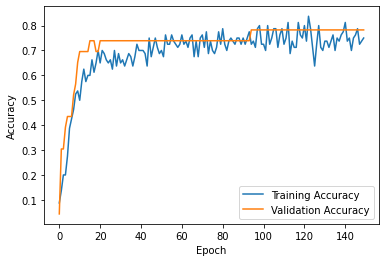

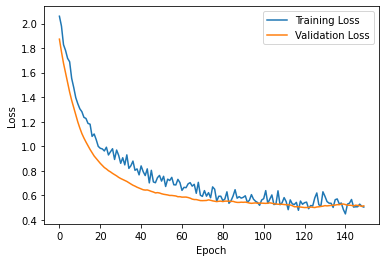

Best validation accuracy: 0.782608687877655
Training accuracy at the best test accuracy: 0.7250000238418579
Best validation accuracy: 0.782608687877655
Training accuracy at the best test accuracy: 0.7250000238418579
Confusion matrix:
[[5 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 9 0 0]
 [0 1 0 2 0 0]
 [0 0 0 2 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 66.66666666666666
Accuracy for 2 : 100.0
Accuracy for 3 : 69.23076923076923
Accuracy for 4 : nan
Accuracy for 5 : 100.0
Total Precision: nan
Total Recall: 0.7222222222222222
Total F1 Score: nan
Accuracy for each label: [100.          66.66666667 100.          69.23076923          nan
 100.        ]
Precision for each label: [1.         0.66666667 1.         0.69230769        nan 1.        ]
Recall for each label: [1.         1.         1.         1.         0.         0.33333333]
F1 Score for each label: [1.         0.8        1.         0.81818182        nan 0.5       ]
Total Accuracy: 78.26086956521739


/tmp/ipykernel_47277/1781135939.py:35: RuntimeWarning: invalid value encountered in divide
  class_accuracies = true_positives / class_data_totals * 100
/tmp/ipykernel_47277/1781135939.py:53: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)


In [17]:
run_model(ratio_4, callback_4)

/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_47277/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_47277/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
23/23 [==============================] - 1s 18ms/step - loss: 1.9432 - accuracy: 0.2584 - val_loss: 1.9526 - val_accuracy: 0.3571
Epoch 2/150
23/23 [==============================] - 0s 5ms/step - loss: 1.9329 - accuracy: 0.2921 - val_loss: 1.8357 - val_accuracy: 0.3571
Epoch 3/150
23/23 [==============================] - 0s 5ms/step - loss: 1.7751 - accuracy: 0.3371 - val_loss: 1.7283 - val_accuracy: 0.3571
Epoch 4/150
23/23 [==============================] - 0s 5ms/step - loss: 1.5987 - accuracy: 0.3483 - val_loss: 1.6369 - val_accuracy: 0.3571
Epoch 5/150
23/23 [==============================] - 0s 9ms/step - loss: 1.5581 - accuracy: 0.4494 - val_loss: 1.5436 - val_accuracy: 0.5714
Epoch 6/150
23/23 [==============================] - 0s 7ms/step - loss: 1.5604 - accuracy: 0.4607 - val_loss: 1.4556 - val_accuracy: 0.6429
Epoch 7/150
23/23 [==============================] - 0s 5ms/step - loss: 1.3616 - accuracy: 0.5506 - val_loss: 1.3747 - val_accuracy: 0.5714
Epoch 8/150


Epoch 59/150
23/23 [==============================] - 0s 5ms/step - loss: 0.6220 - accuracy: 0.7416 - val_loss: 0.5487 - val_accuracy: 0.7143
Epoch 60/150
23/23 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.7191 - val_loss: 0.5428 - val_accuracy: 0.7143
Epoch 61/150
23/23 [==============================] - 0s 4ms/step - loss: 0.6108 - accuracy: 0.7416 - val_loss: 0.5397 - val_accuracy: 0.7143
Epoch 62/150
23/23 [==============================] - 0s 5ms/step - loss: 0.6401 - accuracy: 0.6629 - val_loss: 0.5384 - val_accuracy: 0.7143
Epoch 63/150
23/23 [==============================] - 0s 5ms/step - loss: 0.6243 - accuracy: 0.7528 - val_loss: 0.5377 - val_accuracy: 0.7143
Epoch 64/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5517 - accuracy: 0.7640 - val_loss: 0.5312 - val_accuracy: 0.7143
Epoch 65/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5691 - accuracy: 0.7978 - val_loss: 0.5281 - val_accuracy: 0.7143
Epoch 

23/23 [==============================] - 0s 5ms/step - loss: 0.4753 - accuracy: 0.7753 - val_loss: 0.4972 - val_accuracy: 0.7857
Epoch 117/150
23/23 [==============================] - 0s 5ms/step - loss: 0.5075 - accuracy: 0.7640 - val_loss: 0.4983 - val_accuracy: 0.7857
Epoch 118/150
23/23 [==============================] - 0s 5ms/step - loss: 0.5231 - accuracy: 0.7528 - val_loss: 0.4981 - val_accuracy: 0.7857
Epoch 119/150
23/23 [==============================] - 0s 5ms/step - loss: 0.5552 - accuracy: 0.7416 - val_loss: 0.4967 - val_accuracy: 0.7857
Epoch 120/150
23/23 [==============================] - 0s 5ms/step - loss: 0.5060 - accuracy: 0.7416 - val_loss: 0.4948 - val_accuracy: 0.7857
Epoch 121/150
23/23 [==============================] - 0s 5ms/step - loss: 0.4878 - accuracy: 0.7416 - val_loss: 0.4972 - val_accuracy: 0.7857
Epoch 122/150
23/23 [==============================] - 0s 5ms/step - loss: 0.5220 - accuracy: 0.7753 - val_loss: 0.5006 - val_accuracy: 0.7857
Epoch 123/150

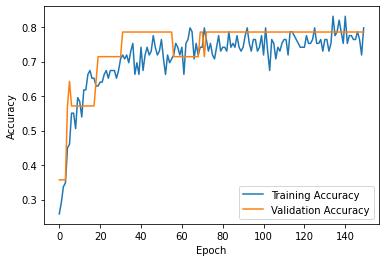

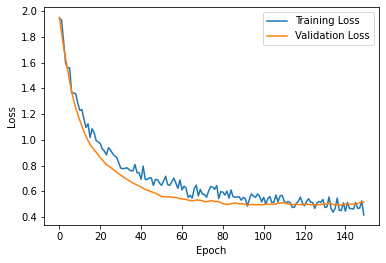

Best validation accuracy: 0.7857142686843872
Training accuracy at the best test accuracy: 0.7191011309623718
Best validation accuracy: 0.7857142686843872
Training accuracy at the best test accuracy: 0.7191011309623718
Confusion matrix:
[[3 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 2 0 0]
 [0 0 0 1 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 62.5
Accuracy for 4 : nan
Accuracy for 5 : 100.0
Total Precision: nan
Total Recall: 0.75
Total F1 Score: nan
Accuracy for each label: [100.  100.  100.   62.5   nan 100. ]
Precision for each label: [1.    1.    1.    0.625   nan 1.   ]
Recall for each label: [1.  1.  1.  1.  0.  0.5]
F1 Score for each label: [1.         1.         1.         0.76923077        nan 0.66666667]
Total Accuracy: 78.57142857142857


/tmp/ipykernel_47277/1781135939.py:35: RuntimeWarning: invalid value encountered in divide
  class_accuracies = true_positives / class_data_totals * 100
/tmp/ipykernel_47277/1781135939.py:53: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)


In [18]:
run_model(ratio_5, callback_5)

# 

# N